# Continuous Wavelet Transformation (CWT) Packages

Explores how MATLAB implements CWT (since it is a commonly used platform for this analysis), then explores open-source options for CWT (focussing on Python).

## Notebook set-up

In [1]:
# Import packages
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywt
from scipy import signal
from ssqueezepy import Wavelet, cwt
from ssqueezepy.utils import make_scales, cwt_scalebounds
from ssqueezepy.visuals import plot, imshow, wavelet_tf_anim

In [2]:
# Import example of a FHR and UCR to be used in notebook (FHR cleaned, UC not)
fhr = pd.read_csv('data_fhr_clean/1001.csv')['FHR'].tail(90*60)
ctg = pd.read_csv('data_csv/1001.csv')
uc = ctg['UC']

## MATLAB cwt()

| Default | Customisation options |
| --- | --- |
| Analytic **morse** wavelet *(note this is morse not morlet - they have similar names!)* | wname = "morse" (default), "amor" (morlet), "bump" |
| Symmetry parameter gamma (γ) = 3 | It's recommended to use a gamma of 3 |
| Time-bandwidth product = 60 | TimeBandwidth = scalar from 3 to 120. Increasing the time-bandwidth product P-squared narrows the wavelet filter in frequency while increasing the width of the central portion of the filter in time. It also increases the number of oscillations of the wavelet under the central portion of the filter. |
| Voices per octave = 10 | VoicesPerOctave = integer from 1 to 48. Common values are 10, 12, 14, 16 and 32. It is about the amount of steps between each octave (which is when the scale is doubled). With higher values, there is finer discretisation of the scale parameter but also greater computation as you're computing CWT for more scales.[[source]](https://uk.mathworks.com/matlabcentral/answers/590947-what-does-voices-per-octave-means) |
| Minimum and maximum scales = determined automatically based on energy spread of wavelet in frequency and time | No - automatically determined |
| L1 normalisation applied so that equal amplitude oscillatory components in data at different scales will have equal magnitude in the CWT | No - appears to be required |
| Sampling frequency is determined from rowtimes of a timetable | fs = positive scalar. If you specify fs then you can't specify ts. If your signal is a timetable, you can't specify fs. A timetable is a type of table that associates a time with each row. |
| Sampling period is determined from rowtimes of a timetable when you set the PeriodLimits name-value argument (e.g. cwt(x, hours(12))) | ts = scalar duration (years, days, hours, minutes, seconds). If you specify ts then you can't specify fs. If x is a timetable then you cannot specify ts.|

[[source]](https://uk.mathworks.com/help/wavelet/ref/cwt.html)

## Python packages for CWT

There are a range of Python packages available:
* **Scipy**
* **Pywavelet** (pwt)
* **scaleogram** (builds on pywt to plot scaleogram more similar to MATLAB) [[GitHub]](https://github.com/alsauve/scaleogram)
* **Ssqueezepy** [[GitHub]](https://github.com/OverLordGoldDragon/ssqueezepy)
* **Librosa** [[documentation]](https://librosa.org/doc/latest/index.html)
* **wavelets** [[GitHub]](https://github.com/chris-torrence/wavelets)
* **LTFAT** (Large Time-Frequency Analysis Toolbox) is open-source MATLAB, you need base MATLAB to run but not any toolboxes, you can also run with Octave[[source]](https://ltfat.org/) and there is a partial python port [[pypi]](https://pypi.org/project/ltfatpy/)
* **PyCWT**
* **GhostiPy**
* **waipy**
* **kPywavelets**

Commonly, there is a dislike of some of the initial packages you might come across for Python CWT implementation (scipy, pwt), that they are confusing to use and that the parameters you input are not intuitive.

At the DSP online conference, recommendations were LTFAT, squeezepy, Librosa and wavelets.[[source]](https://www.dsponlineconference.com/meeting/Live_Discussion_Time_Frequency_Analysis_for_Signal_Processing)

Supported wavelets...

| Package | Morse | Morlet | Bump | Mexican hat/ricker | Gaussian | Shannon | Frequency B-spline | Hermitian Hat |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| MATLAB | Yes | Yes | Yes | No | No | No | No | No |
| Scipy | No | Yes | ? | Yes | ? | ? | ? | No |
| Pywt | No | Yes | ? | Yes | Yes | Yes | Yes | No |
| PyCWT | ? | ? | ? | ? | ? | ? | ? | No |
| Ssqueezepy | Yes | Yes | Yes | Yes | No | No | No | Yes |

## Scipy

This was how I implemented on `04_introduction_to_signal_transformation` and `05_scipy_cwt_scaleogram_variants.ipynb`.

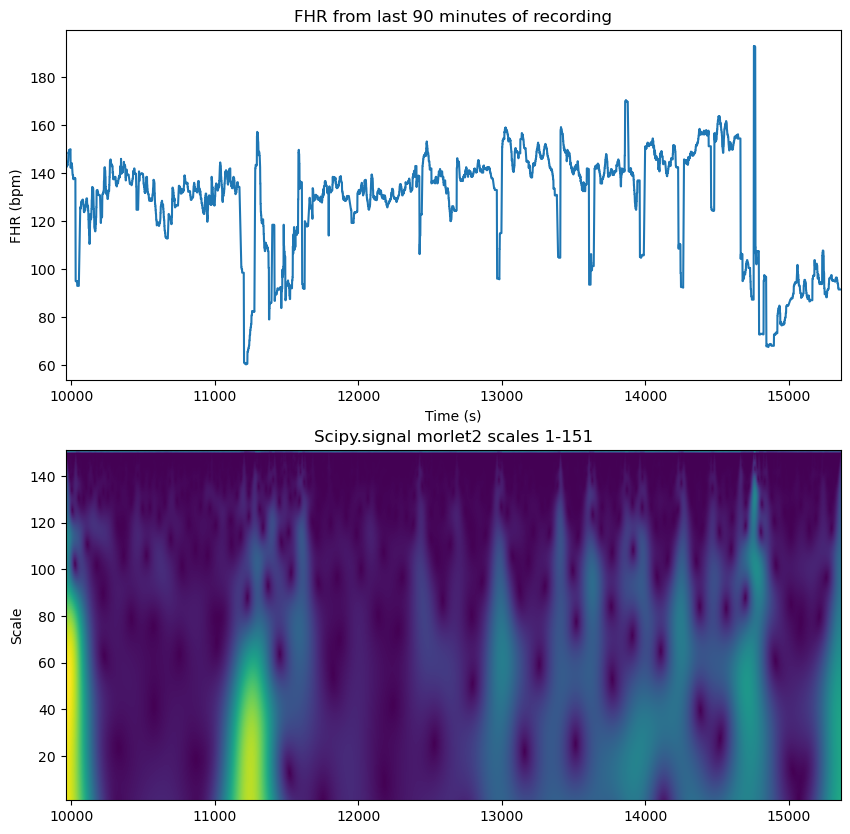

In [3]:
# Plot FHR
fig, axes = plt.subplots(nrows=2, figsize=(10, 10))
axes[0].plot(fhr)
axes[0].margins(x=0)
axes[0].set_title('FHR from last 90 minutes of recording')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('FHR (bpm)')

# Perform CWT with Morlet and plot
cwtmatr = signal.cwt(fhr, signal.morlet2, np.arange(1, 151))

# Plot the spectogram
magn = np.absolute(cwtmatr)
axes[1].imshow(magn, extent=[min(fhr.index), max(fhr.index), 1, 151], aspect='auto')
axes[1].set_ylabel('Scale')
axes[1].set_title('Scipy.signal morlet2 scales 1-151')
plt.show()

## Pywavelets

In [4]:
print(pywt.wavelist(kind='continuous'))

['cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'mexh', 'morl', 'shan']


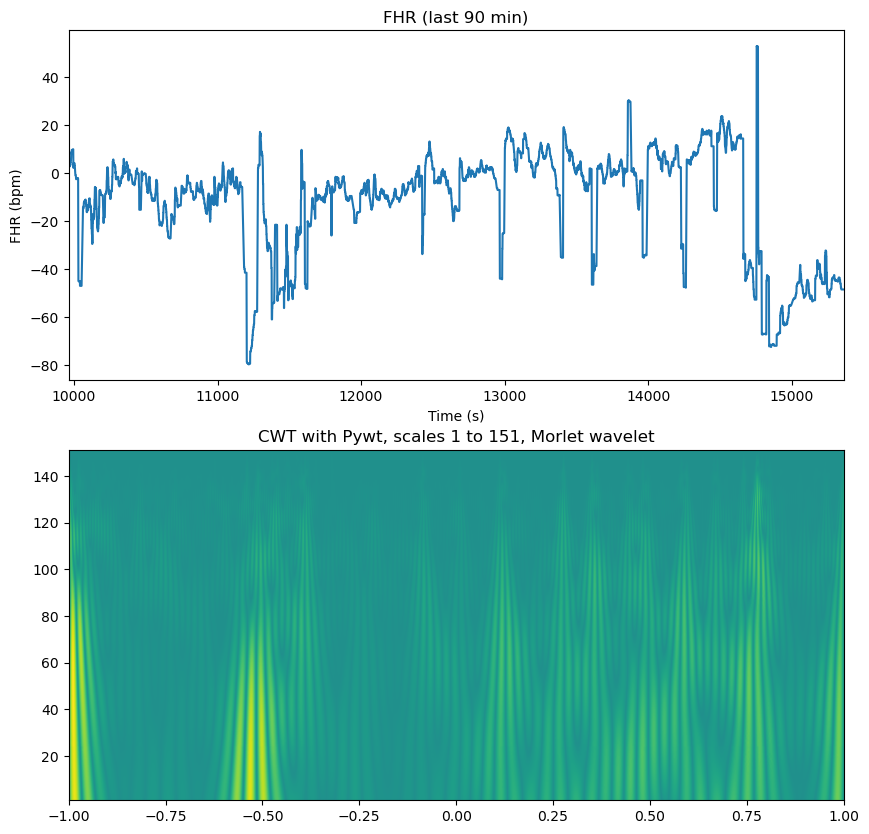

In [5]:
# Plot FHR
fig, axes = plt.subplots(nrows=2, figsize=(10, 10))
axes[0].plot(fhr-140)
axes[0].margins(x=0)
axes[0].set_title('FHR (last 90 min)')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('FHR (bpm)')

# Perform CWT using pywt and plot scaleogram
cwtmatr, freqs = pywt.cwt(data=fhr, scales=np.arange(1, 151), wavelet='morl')
mag = abs(cwtmatr)
plt.imshow(mag, extent=[-1, 1, 1, 151], aspect='auto',
           vmax=mag.max(), vmin=-mag.max()) 
plt.title('CWT with Pywt, scales 1 to 151, Morlet wavelet')
plt.show()

## Ssqueezepy

Supported wavelets: 'gmw' (generalised morse wavelet), 'morlet', 'bump', 'cmhat' (complex mexican hat), 'hhhat' (Hilbert analytic function of Hermitian Hat)

In [6]:
Wavelet.SUPPORTED

{'bump', 'cmhat', 'gmw', 'hhhat', 'morlet'}

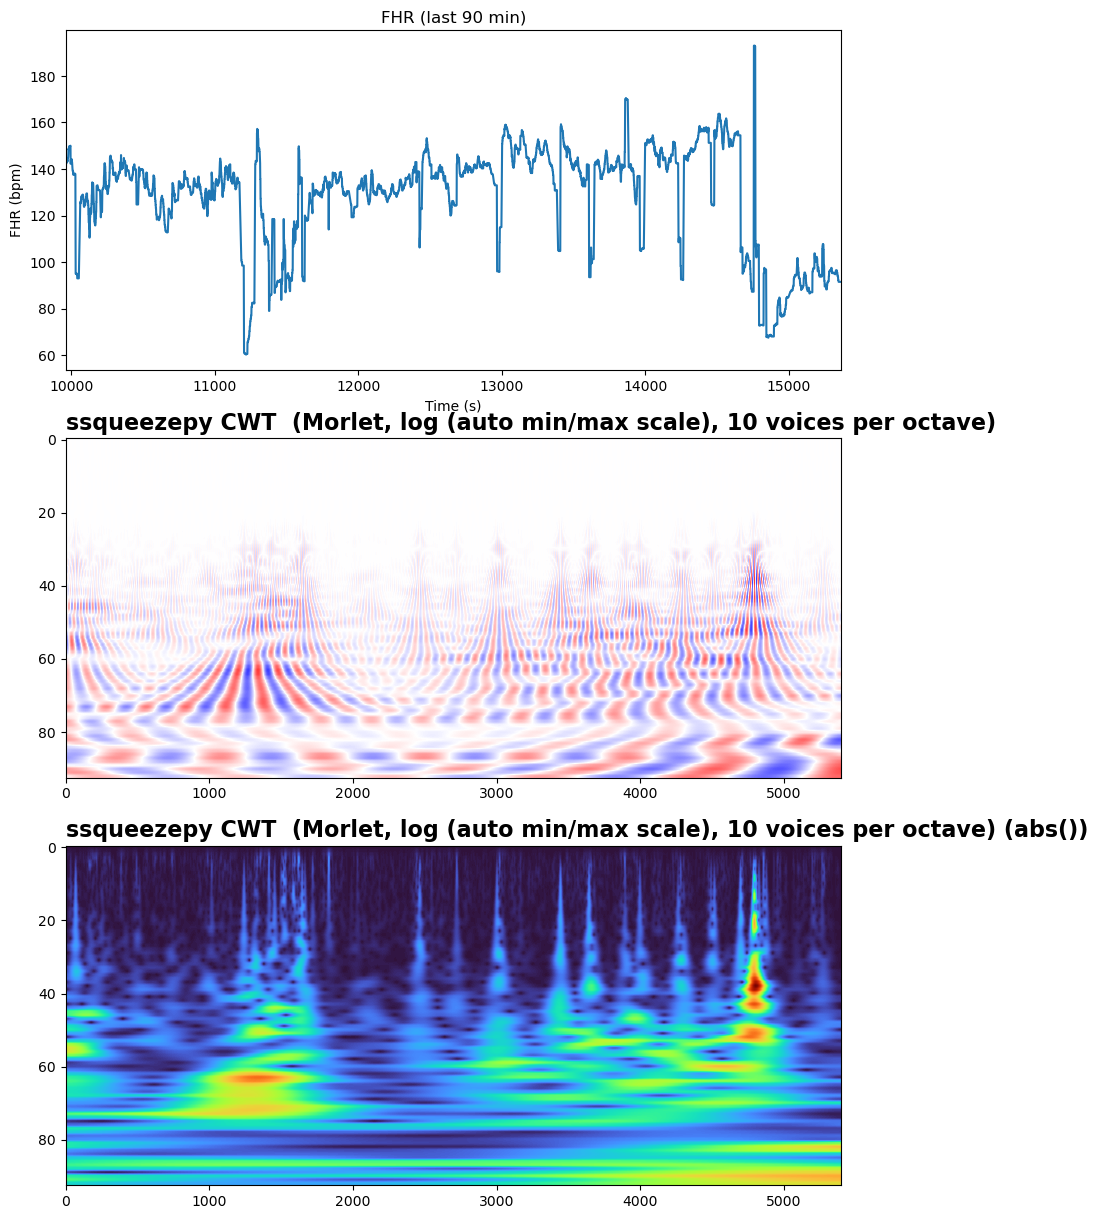

In [7]:
# Plot FHR
fig, axes = plt.subplots(nrows=3, figsize=(10, 15))
axes[0].plot(fhr)
axes[0].margins(x=0)
axes[0].set_title('FHR (last 90 min)')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('FHR (bpm)')

# Configure
wavelet = Wavelet('morlet')
voices_per_octave = 10

# Make scales (nv is number of voices/wavelets per octave)
min_scale, max_scale = cwt_scalebounds(wavelet, len(fhr))
scales = make_scales(len(fhr), scaletype='log', nv=voices_per_octave,
                     min_scale=min_scale, max_scale=max_scale)

# Perform CWT
Wx, _ = cwt(fhr, wavelet, scales=scales)

# Visualise - taking abs(data) before plotting or not
imshow(Wx, abs=0, ax=axes[1], show=False,
       title='ssqueezepy CWT  (Morlet, log (auto min/max scale), 10 voices per octave)') 
imshow(Wx, abs=1, ax=axes[2], show=False,
       title='ssqueezepy CWT  (Morlet, log (auto min/max scale), 10 voices per octave) (abs())') 

plt.show()